## Observations

- Abstracts provide no useful summarization... everything is more on the 'hook' side that gets pulled out 
- See below for entity extraction counts 

In [1]:
import pandas as pd
import re

In [2]:
MIND_w_topics=pd.read_csv("~/efs/home/pcorona_content/MIND_Train_w_Topics.csv")
MIND_w_topics.sort_values(by=['Title', '_score_'], ascending=False, inplace=True)
MIND_w_topics.drop_duplicates(subset=['__uniqueid__'], keep='first', inplace=True)
MIND_w_topics = MIND_w_topics.reset_index() 
MIND_w_topics.head()

,index,__uniqueid__,Text,_category_,keywords,_score_,Category level_1,Category level_2,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities
0,88706,162115,The State Medical Examiner's Office confirmed ...,Law Enforcement,Police | Office | Police | police | Police | a...,59,Law Enforcement,NaN,N121883,news,newscrime,"﻿Body identified, boyfriend charged with murde...",The State Medical Examiner's Office confirmed ...,https://s3.amazonaws.com/las.scads.public/F890...,"[{""Label"": ""Waterville, Maine"", ""Type"": ""G"", ""...","[{""Label"": ""Waterville, Maine"", ""Type"": ""G"", ""..."
1,115886,498810,Devan Makail Bradish died Oct. 27. He was the ...,NaN,NaN,.,NaN,NaN,N110380,lifestyle,lifestylefamily,​Devan Makail Bradish: Obituary,The Nov. 3 funeral will memorialize a teen who...,https://s3.amazonaws.com/las.scads.public/F890...,[],[]
2,35888,140606,The Astros are the best team in baseball. Most...,Baseball,Astros | team | team | Yankees | Yankees | tea...,26,Baseball,NaN,N12568,sports,baseball_mlb,​Are the Astros stealing signs to gain an edge...,"If your code is easy to crack, the problem is ...",https://s3.amazonaws.com/las.scads.public/F890...,"[{""Label"": ""Houston Astros"", ""Type"": ""O"", ""Wik...",[]
3,138406,318115,I’ve always been a pretty healthy person. I ba...,Family,feel | feel | feel | something | doctor | alwa...,54,Family,NaN,N68164,health,ads-lung-health,​'My Annoying Cough Turned Out To Be Lung Cancer',"As soon as I was coming out of anesthesia, he ...",https://s3.amazonaws.com/las.scads.public/F890...,[],[]
4,25490,34104,"""Condition Confessions"" is a new series by Wom...",Family,love | always | friends | think | felt | love ...,71,Family,NaN,N46735,health,voices,​'How I Told My Siblings I Had Lung Cancer',Her chronic back pain turned out to be somethi...,https://s3.amazonaws.com/las.scads.public/F890...,"[{""Label"": ""Lung cancer"", ""Type"": ""C"", ""Wikida...",[]


In [3]:
MIND_w_topics['title_entities_names'] = [re.findall(r"\"Label\": \"(.*?)\",", str(x)) for x in MIND_w_topics['Title Entities']]
MIND_w_topics['title_entities_type'] = [re.findall(r"\"Type\": \"(.*?)\",", str(x)) for x in MIND_w_topics['Title Entities']]
MIND_w_topics['title_entities_wikiid'] = [re.findall(r"\"WikidataId\": \"(.*?)\",", str(x)) for x in MIND_w_topics['Title Entities']]

In [4]:
MIND_w_topics.head()

,index,__uniqueid__,Text,_category_,keywords,_score_,Category level_1,Category level_2,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities,title_entities_names,title_entities_type,title_entities_wikiid
0,88706,162115,The State Medical Examiner's Office confirmed ...,Law Enforcement,Police | Office | Police | police | Police | a...,59,Law Enforcement,NaN,N121883,news,newscrime,"﻿Body identified, boyfriend charged with murde...",The State Medical Examiner's Office confirmed ...,https://s3.amazonaws.com/las.scads.public/F890...,"[{""Label"": ""Waterville, Maine"", ""Type"": ""G"", ""...","[{""Label"": ""Waterville, Maine"", ""Type"": ""G"", ""...","[Waterville, Maine]",[G],[Q997170]
1,115886,498810,Devan Makail Bradish died Oct. 27. He was the ...,NaN,NaN,.,NaN,NaN,N110380,lifestyle,lifestylefamily,​Devan Makail Bradish: Obituary,The Nov. 3 funeral will memorialize a teen who...,https://s3.amazonaws.com/las.scads.public/F890...,[],[],[],[],[]
2,35888,140606,The Astros are the best team in baseball. Most...,Baseball,Astros | team | team | Yankees | Yankees | tea...,26,Baseball,NaN,N12568,sports,baseball_mlb,​Are the Astros stealing signs to gain an edge...,"If your code is easy to crack, the problem is ...",https://s3.amazonaws.com/las.scads.public/F890...,"[{""Label"": ""Houston Astros"", ""Type"": ""O"", ""Wik...",[],[Houston Astros],[O],[Q848117]
3,138406,318115,I’ve always been a pretty healthy person. I ba...,Family,feel | feel | feel | something | doctor | alwa...,54,Family,NaN,N68164,health,ads-lung-health,​'My Annoying Cough Turned Out To Be Lung Cancer',"As soon as I was coming out of anesthesia, he ...",https://s3.amazonaws.com/las.scads.public/F890...,[],[],[],[],[]
4,25490,34104,"""Condition Confessions"" is a new series by Wom...",Family,love | always | friends | think | felt | love ...,71,Family,NaN,N46735,health,voices,​'How I Told My Siblings I Had Lung Cancer',Her chronic back pain turned out to be somethi...,https://s3.amazonaws.com/las.scads.public/F890...,"[{""Label"": ""Lung cancer"", ""Type"": ""C"", ""Wikida...",[],[Lung cancer],[C],[Q47912]


<AxesSubplot:>

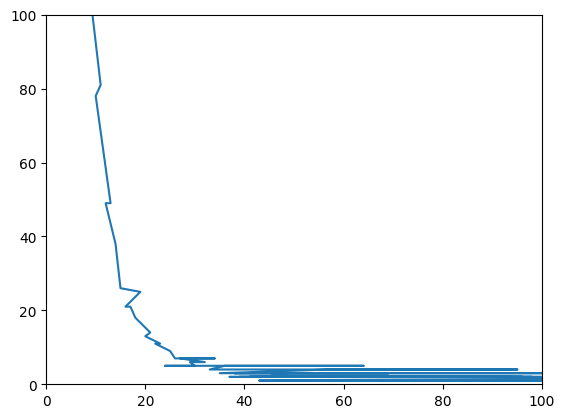

In [5]:
# QUANTITY of documents contain the SAME full set of entities
MIND_w_topics.groupby([str(x) for x in MIND_w_topics['title_entities_names']])['Text'].count().value_counts().plot(ylim=[0, 100], xlim=[0, 100])

count    21627.000000
mean         4.967263
std         24.219610
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1481.000000
dtype: float64


<AxesSubplot:>

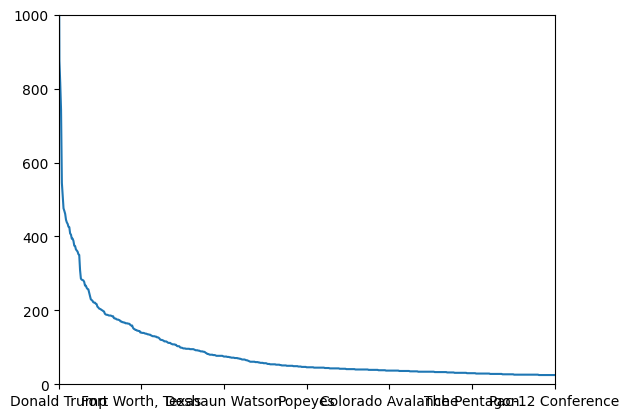

In [6]:
# QUANTITY of documents contain ANY of one entity
anyone = pd.DataFrame(MIND_w_topics['title_entities_names'].tolist()).stack().value_counts()
print(anyone.describe())
anyone.plot(ylim=[0,1000], xlim=[0,600])

In [7]:
# Entity Type 
pd.DataFrame(MIND_w_topics['title_entities_type'].tolist()).stack().value_counts()

O    31518
P    25109
G    23842
U     6239
C     4995
F     3368
N     2836
S     1792
W     1309
E     1180
M     1046
L      864
H      836
B      732
V      696
J      547
K      217
Y      137
R      112
Q       20
I       17
A       15
dtype: int64

### Testing some summarizations with different entity types 


In [8]:
import multisum as msu

In [14]:
def run_sum(df): 
    documents, doc_incidences, load_time = msu.load_corpus(df, 'Text') 
    msu.summarize_collect(df, documents, doc_incidences, 'position', 150, False)
    # msu.summarize_collect(df, documents, doc_incidences, 'fisher', 150, False) # #Must first compute bigrams if we want to run with Fisher 
    msu.summarize_collect(df, documents, doc_incidences, 'sentances', 150, False)

In [15]:
# Q9682 - Elizabeth II
queen = MIND_w_topics[["Q9682" in x for x in MIND_w_topics['title_entities_wikiid']]].reset_index()
print("\nResults for Elizabeth II")
run_sum(queen)

# Q1215884 - National Football League
foot = MIND_w_topics[["Q1215884" in x for x in MIND_w_topics['title_entities_wikiid']]].reset_index()
print("\nResults for National Football League")
run_sum(foot)

# geographic entity - Tennesse
print("\nResults for Tenneseee")
geo = MIND_w_topics[["Q1509" in x for x in MIND_w_topics['title_entities_wikiid']]].reset_index()
run_sum(geo)

# vehicle - Porsche
print("\nResults for Porsche (vehicles)")
v = MIND_w_topics[["Q219357" in x for x in MIND_w_topics['title_entities_wikiid']]].reset_index()
run_sum(v)

# technology - IPhone 
print("\nResults for Iphone")
pho = MIND_w_topics[["Q23309966" in x for x in MIND_w_topics['title_entities_wikiid']]].reset_index()
run_sum(pho)


Results for Elizabeth II
-------------------

Summarizing 6 documents under scheme position
Summary time: 0.005240440368652344
Summary generated in 1086403 ns

 -----summary------ 

Queen Elizabeth's bodyguards call her "Sharon" when out in public for safety purposes, according to The Sun.                                          (The Queen's royal protection officers reportedly use this secret code name for her when out in public)
One of the year’s outstanding programs, season three of Netflix’s “The Crown” presents the British royal family as surprisingly poignant, vulnerable and likable.(Beatrice will be the first princess in the Queen's family to become a stepmother)
If you keep up with royal headlines, you'll recall that Queen Elizabeth surprisingly has a great sense of humor despite her proper appearance.        (The Queen's royal protection officers reportedly use this secret code name for her when out in public)
At 93, she's well past the age at which most people retire; and y

In [11]:
# Selecting more entities to try based on organization type 
MIND_w_topics[['title_entities_names', 'title_entities_wikiid', 'title_entities_type']][0:50]

,title_entities_names,title_entities_wikiid,title_entities_type
0,"[Waterville, Maine]",[Q997170],[G]
1,[],[],[]
2,[Houston Astros],[Q848117],[O]
3,[],[],[]
4,[Lung cancer],[Q47912],[C]
5,[Northern Kentucky],[Q7058599],[U]
6,[],[],[]
7,"[Lori Lightfoot, Canada goose]","[Q56486914, Q26733]","[N, U]"
8,"[Chicago Bears, Mitchell Trubisky, Lori Lightf...","[Q205033, Q26405845, Q56486914, Q780442]","[O, P, N, O]"
9,[Walt Williams],[Q1458276],[P]
